In [ ]:
#KGABE RONALD MOLEPO
#DATA DRIVEN COMPETITION
#H1N1

In [49]:
# ENVIRONMENT SETUP
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [50]:
# Load the data
train_features = pd.read_csv('training_set_features.csv')
train_labels = pd.read_csv('training_set_labels.csv')
test_features = pd.read_csv('test_set_features.csv')

# Merge features and labels for exploration
full_train = pd.merge(train_features, train_labels, on='respondent_id')

# Basic exploration
print("Training features shape:", train_features.shape)
print("Training labels shape:", train_labels.shape)
print("Test features shape:", test_features.shape)

# Check for missing values
print("\nMissing values in training set:")
print(train_features.isnull().sum().sort_values(ascending=False))

# Examine target variable distribution
print("\nTarget variable distribution:")
print(train_labels[['h1n1_vaccine', 'seasonal_vaccine']].mean())

Training features shape: (26707, 36)
Training labels shape: (26707, 3)
Test features shape: (26708, 36)

Missing values in training set:
employment_occupation          13470
employment_industry            13330
health_insurance               12274
income_poverty                  4423
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
rent_or_own                     2042
employment_status               1463
marital_status                  1408
education                       1407
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
opinion_seas_sick_from_vacc      537
opinion_seas_risk                514
opinion_seas_vacc_effective      462
opinion_h1n1_sick_from_vacc      395
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
household_children               249
household_adults                 249
behavioral_avoidance             208
behavioral_touch_face            128
h1n1_knowled

In [51]:
# Data Preprocessing 
# We have to handle:
  #Missing values
  #Categorical encoding
  #Feature scaling

# Define numeric and categorical features
numeric_features = ['h1n1_concern', 'h1n1_knowledge', 
                   'behavioral_antiviral_meds', 'behavioral_avoidance',
                   'behavioral_face_mask', 'behavioral_wash_hands',
                   'behavioral_large_gatherings', 'behavioral_outside_home',
                   'behavioral_touch_face', 'doctor_recc_h1n1',
                   'doctor_recc_seasonal', 'chronic_med_condition',
                   'child_under_6_months', 'health_worker',
                   'health_insurance', 'opinion_h1n1_vacc_effective',
                   'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
                   'opinion_seas_vacc_effective', 'opinion_seas_risk',
                   'opinion_seas_sick_from_vacc', 'household_adults',
                   'household_children']

categorical_features = ['age_group', 'education', 'race', 'sex',
                      'income_poverty', 'marital_status', 'rent_or_own',
                      'employment_status', 'hhs_geo_region', 'census_msa',
                      'employment_industry', 'employment_occupation']

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [52]:
#####                         MODEL    TRAINING

In [53]:
# FIRST MODEL = RANDOM FOREST

# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(
    train_features, 
    train_labels[['h1n1_vaccine', 'seasonal_vaccine']],
    test_size=0.2,
    random_state=42
)

# Preprocess the data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# Train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_processed, y_train)

# Evaluate on validation set
rf_val_preds = rf_model.predict_proba(X_val_processed)
rf_h1n1_auc = roc_auc_score(y_val['h1n1_vaccine'], rf_val_preds[0][:, 1])
rf_seasonal_auc = roc_auc_score(y_val['seasonal_vaccine'], rf_val_preds[1][:, 1])
rf_mean_auc = (rf_h1n1_auc + rf_seasonal_auc) / 2

print(f"Random Forest Validation AUC - H1N1: {rf_h1n1_auc:.4f}")
print(f"Random Forest Validation AUC - Seasonal: {rf_seasonal_auc:.4f}")
print(f"Random Forest Mean Validation AUC: {rf_mean_auc:.4f}")

Random Forest Validation AUC - H1N1: 0.8307
Random Forest Validation AUC - Seasonal: 0.8540
Random Forest Mean Validation AUC: 0.8423


In [54]:
# SECOND MODEL = XGBOOST
# XGBoost model with MultiOutputClassifier
xgb_model = MultiOutputClassifier(
    XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
)

xgb_model.fit(X_train_processed, y_train)

# Evaluate on validation set
xgb_val_preds = xgb_model.predict_proba(X_val_processed)
xgb_h1n1_auc = roc_auc_score(y_val['h1n1_vaccine'], xgb_val_preds[0][:, 1])
xgb_seasonal_auc = roc_auc_score(y_val['seasonal_vaccine'], xgb_val_preds[1][:, 1])
xgb_mean_auc = (xgb_h1n1_auc + xgb_seasonal_auc) / 2

print(f"XGBoost Validation AUC - H1N1: {xgb_h1n1_auc:.4f}")
print(f"XGBoost Validation AUC - Seasonal: {xgb_seasonal_auc:.4f}")
print(f"XGBoost Mean Validation AUC: {xgb_mean_auc:.4f}")

XGBoost Validation AUC - H1N1: 0.8302
XGBoost Validation AUC - Seasonal: 0.8584
XGBoost Mean Validation AUC: 0.8443


In [55]:
# THIRD MODEL = LOGISTIC REGRESSION
# Logistic Regression model
lr_model = MultiOutputClassifier(
    LogisticRegression(
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    )
)

lr_model.fit(X_train_processed, y_train)

# Evaluate on validation set
lr_val_preds = lr_model.predict_proba(X_val_processed)
lr_h1n1_auc = roc_auc_score(y_val['h1n1_vaccine'], lr_val_preds[0][:, 1])
lr_seasonal_auc = roc_auc_score(y_val['seasonal_vaccine'], lr_val_preds[1][:, 1])
lr_mean_auc = (lr_h1n1_auc + lr_seasonal_auc) / 2

print(f"Logistic Regression Validation AUC - H1N1: {lr_h1n1_auc:.4f}")
print(f"Logistic Regression Validation AUC - Seasonal: {lr_seasonal_auc:.4f}")
print(f"Logistic Regression Mean Validation AUC: {lr_mean_auc:.4f}")

Logistic Regression Validation AUC - H1N1: 0.8319
Logistic Regression Validation AUC - Seasonal: 0.8561
Logistic Regression Mean Validation AUC: 0.8440


In [56]:
# FOUTRTH MODEL = LIGHTGBM
# LightGBM model with MultiOutputClassifier
lgbm_model = MultiOutputClassifier(
    LGBMClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=10,
        num_leaves=40,
        min_split_gain=0.0,
        random_state=42,
        n_jobs=-1
    )
)

# Fit the model
lgbm_model.fit(X_train_processed, y_train)

# Predict probabilities
lgbm_val_preds = lgbm_model.predict_proba(X_val_processed)

# Evaluate AUC
lgbm_h1n1_auc = roc_auc_score(y_val['h1n1_vaccine'], lgbm_val_preds[0][:, 1])
lgbm_seasonal_auc = roc_auc_score(y_val['seasonal_vaccine'], lgbm_val_preds[1][:, 1])
lgbm_mean_auc = (lgbm_h1n1_auc + lgbm_seasonal_auc) / 2

# Print results
print(f"LightGBM Validation AUC - H1N1: {lgbm_h1n1_auc:.4f}")
print(f"LightGBM Validation AUC - Seasonal: {lgbm_seasonal_auc:.4f}")
print(f"LightGBM Mean Validation AUC: {lgbm_mean_auc:.4f}")

[LightGBM] [Info] Number of positive: 4544, number of negative: 16821
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 21365, number of used features: 112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212684 -> initscore=-1.308820
[LightGBM] [Info] Start training from score -1.308820
[LightGBM] [Info] Number of positive: 9984, number of negative: 11381
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 21365, number of used features: 112
[LightGBM] [Info] [b

In [57]:
# FINAL MODEL TRAINING AND PREDICTION

# Preprocess all training data
X_full_processed = preprocessor.fit_transform(train_features)
y_full = train_labels[['h1n1_vaccine', 'seasonal_vaccine']]

# Train final LightGBM model on full training data
final_model = MultiOutputClassifier(
    LGBMClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=-1,            # allow deeper trees
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=10,
        num_leaves=40,
        min_split_gain=0.0,
        random_state=42,
        n_jobs=-1
    )
)

final_model.fit(X_full_processed, y_full)

# Preprocess test data
X_test_processed = preprocessor.transform(test_features)

# Make predictions on test set
test_preds = final_model.predict_proba(X_test_processed)

# Prepare submission file
submission_df = pd.DataFrame({
    'respondent_id': test_features['respondent_id'],
    'h1n1_vaccine': test_preds[0][:, 1],
    'seasonal_vaccine': test_preds[1][:, 1]
})

# Save submission file
submission_df.to_csv('submission.csv', index=False)
print("Submission file created successfully!")

[LightGBM] [Info] Number of positive: 5674, number of negative: 21033
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 26707, number of used features: 112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212454 -> initscore=-1.310198
[LightGBM] [Info] Start training from score -1.310198
[LightGBM] [Info] Number of positive: 12435, number of negative: 14272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 26707, number of used features: 112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465608 -> initscore=-0.137784
[Li

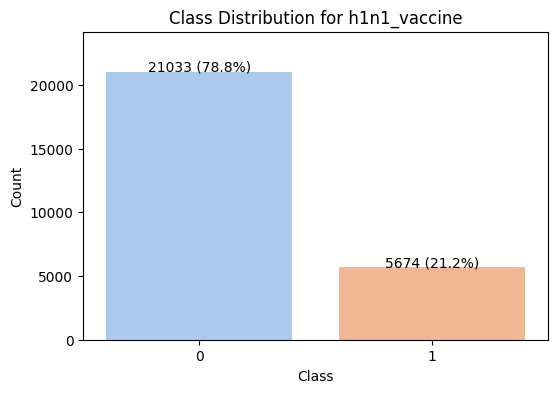

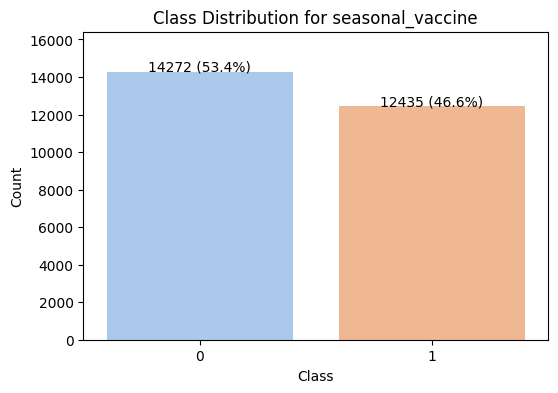

In [58]:
# CLASS DISTRIBUTION WITH PERCENTAGE

def plot_class_distribution(y, label):
    counts = y[label].value_counts().sort_index()
    percentages = counts / counts.sum() * 100
    plt.figure(figsize=(6,4))
    sns.barplot(x=counts.index, y=counts.values, palette="pastel")
    for i, (count, pct) in enumerate(zip(counts, percentages)):
        plt.text(i, count + 50, f'{count} ({pct:.1f}%)', ha='center')
    plt.title(f'Class Distribution for {label}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.ylim(0, counts.max() * 1.15)
    plt.show()

plot_class_distribution(y_full, 'h1n1_vaccine')
plot_class_distribution(y_full, 'seasonal_vaccine')

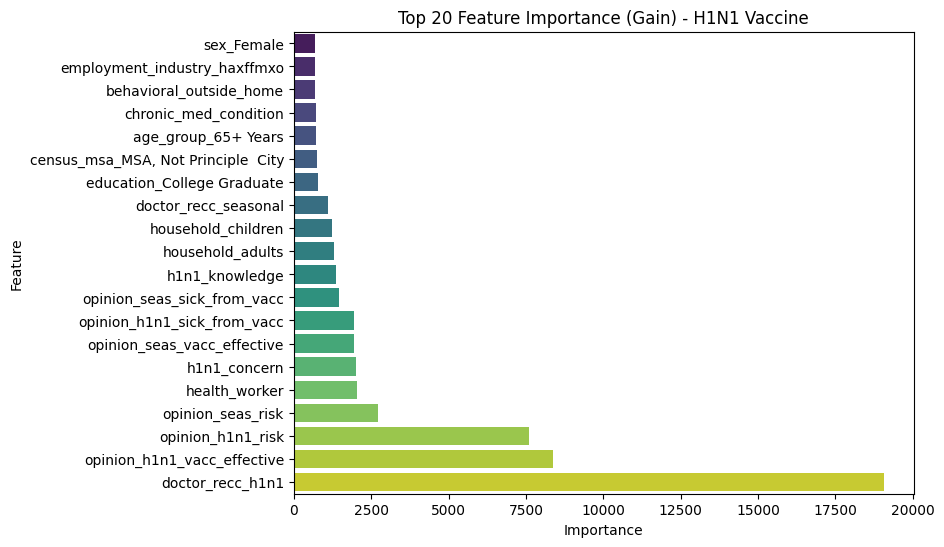

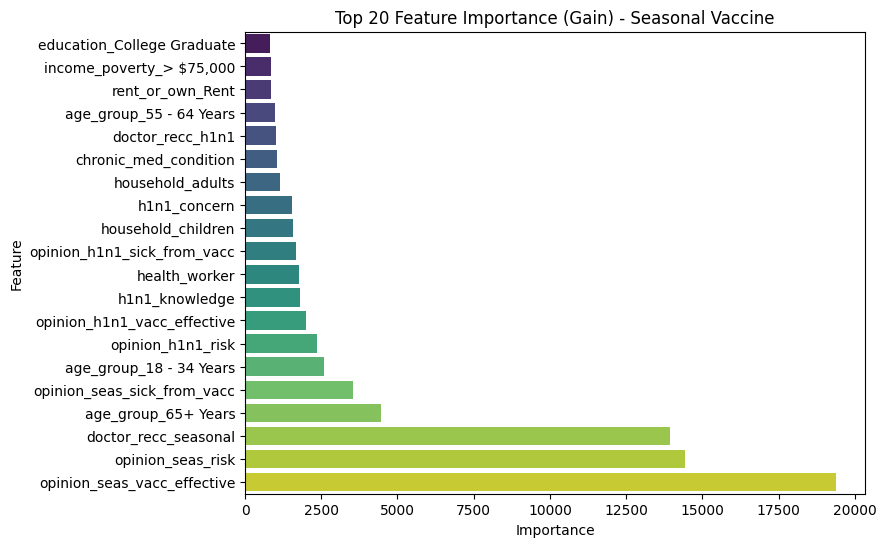

In [65]:
# FEATURE IMPORTANCE PLOT (Gain-based, Top 20)

# H1N1

# Extract feature names from OneHotEncoder after preprocessing
# This assumes you have access to your preprocessor to get feature names:
num_features = numeric_features
cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_features = list(num_features) + list(cat_features)

# Get feature importance from LightGBM (for first target)
importance = final_model.estimators_[0].booster_.feature_importance(importance_type='gain')
feat_imp_df = pd.DataFrame({'feature': all_features, 'importance': importance})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=True).tail(20)

plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df, palette="viridis")
plt.title('Top 20 Feature Importance (Gain) - H1N1 Vaccine')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# SEASONAL

# Extract feature names from OneHotEncoder after preprocessing
# This assumes you have access to your preprocessor to get feature names:
num_features = numeric_features
cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_features = list(num_features) + list(cat_features)

# Get feature importance from LightGBM (for first target)
importance = final_model.estimators_[1].booster_.feature_importance(importance_type='gain')
feat_imp_df = pd.DataFrame({'feature': all_features, 'importance': importance})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=True).tail(20)

plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df, palette="viridis")
plt.title('Top 20 Feature Importance (Gain) - Seasonal Vaccine')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


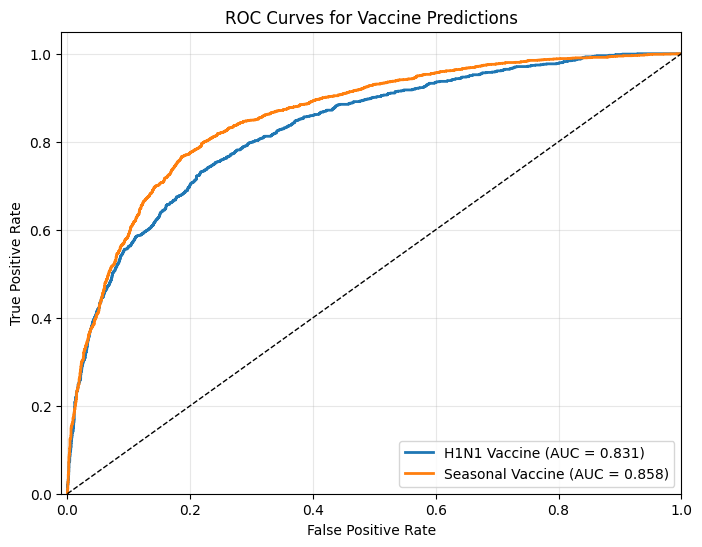

In [60]:
# ROC CURVE FOR BOTH TARGETS

def plot_roc_curve(y_true, y_scores, label):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.3f})')

plt.figure(figsize=(8,6))
plot_roc_curve(y_val['h1n1_vaccine'], lgbm_val_preds[0][:,1], 'H1N1 Vaccine')
plot_roc_curve(y_val['seasonal_vaccine'], lgbm_val_preds[1][:,1], 'Seasonal Vaccine')
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Vaccine Predictions')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

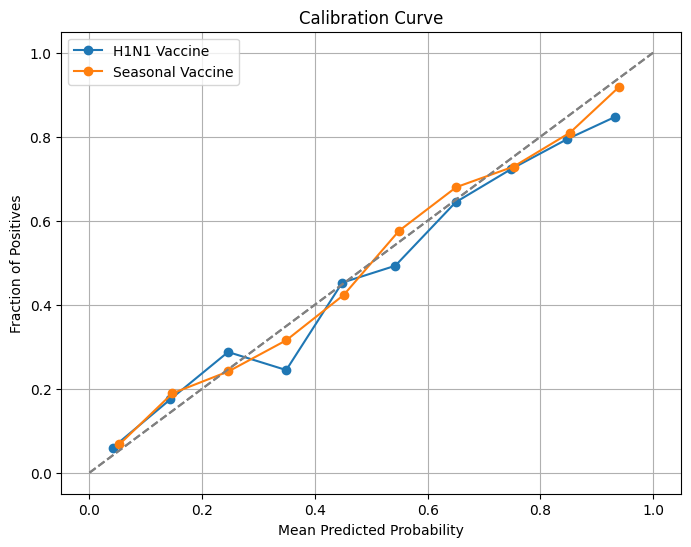

In [61]:
# CALIBRATION CURVE

def plot_calibration_curve(y_true, y_probs, label, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_probs[:, 1], n_bins=n_bins)
    plt.plot(prob_pred, prob_true, marker='o', label=label)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.legend()
    plt.grid(True)

plt.figure(figsize=(8,6))
plot_calibration_curve(y_val['h1n1_vaccine'], lgbm_val_preds[0], 'H1N1 Vaccine')
plot_calibration_curve(y_val['seasonal_vaccine'], lgbm_val_preds[1], 'Seasonal Vaccine')
plt.show()

